### Dependences

In [1]:
import sys
sys.path.append("../")

import math
from tqdm import tqdm
import numpy as np
import tensorflow as tf

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output

from lib.models.Res_UNet import Res_UNet
import lib.utils as utils


### Loading experiment data

In [2]:
#set experiment ID
EXP_ID = "Res_UNet"
utils.create_experiment_folders(EXP_ID)
utils.load_experiment_data()


### Model instantiation

In [3]:
model = Res_UNet()
model.build((None,128,128,1))
print(model.summary())


Model: "res_u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 32)      448       
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 64)        18752     
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 128)       74368     
_________________________________________________________________
sequential_3 (Sequential)    (None, 16, 16, 256)       296192    
_________________________________________________________________
sequential_4 (Sequential)    (None, 8, 8, 512)         1182208   
_________________________________________________________________
sequential_5 (Sequential)    (None, 4, 4, 1024)        47

### Loading Dataset

In [4]:
train_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_train.npy", mmap_mode='c') 
train_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_train.npy", mmap_mode='c') 

qtd_traning = train_x.shape
print("Loaded",qtd_traning, "samples")


Loaded (371026, 128, 128, 1) samples


In [5]:
valid_x_1 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_val.npy", mmap_mode='c') 
valid_y_1 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val.npy", mmap_mode='c')


qtd_traning = valid_x_1.shape
print("Loaded",qtd_traning, "samples")


Loaded (92800, 128, 128, 1) samples


### Dataset Normalization and Batches split

In [6]:
value = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/scale_and_shift.npy", mmap_mode='c') 
print(value)
SHIFT_VALUE_X, SHIFT_VALUE_Y, SCALE_VALUE_X, SCALE_VALUE_Y = value[0], value[1], value[2], value[3]
# SHIFT_VALUE_X, SHIFT_VALUE_Y, SCALE_VALUE_X, SCALE_VALUE_Y = utils.get_shift_scale_maxmin(train_x, train_y, valid_x_1, valid_y_1)

mini_batch_size = 58
num_train_minibatches = math.floor(train_x.shape[0]/mini_batch_size)
num_val_minibatches = math.floor(valid_x_1.shape[0]/mini_batch_size)



print("train_batches:", num_train_minibatches, "valid_batches:", num_val_minibatches)


[ -0.          -0.         127.97928619 127.98652649]
train_batches: 6397 valid_batches: 1600


### Metrics

In [7]:
#default tf.keras metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')

### Set Loss and load model weights

In [8]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#get last saved epoch index and best result in validation step
CURRENT_EPOCH, BEST_VALIDATION = utils.get_model_last_data()
if CURRENT_EPOCH > 0:
    print("Loading last model state in epoch", CURRENT_EPOCH)
    model.load_weights(utils.get_exp_folder_last_epoch())
    print("Best validation result was PSNR=", BEST_VALIDATION)

Loading last model state in epoch 100
Best validation result was PSNR= 55.90195032288531


### Training

In [ ]:
@tf.function
def train_step(patch_x, patch_y):
    with tf.GradientTape() as tape:
        predictions = model(patch_x)
        loss = loss_object(patch_y, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)

def valid_step(valid_x, valid_y, num_val_minibatches, mini_batch_size):
    valid_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
    valid_custom_metrics = utils.CustomMetric()
    for i in tqdm(range(num_val_minibatches)):
        data_x = valid_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        data_y = valid_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        
        data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
        data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)
        
        data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA
        
        predictions = model(data_x)
        valid_mse(data_y, predictions)

        predictions = predictions.numpy()
        data_y = data_y.numpy()
        
        #feed the metric evaluator
        valid_custom_metrics.feed(data_y, predictions)

        #just show the first example of the first batch
#         if i == 0:
#             print("Spatial domain: X - Y - PREDICT")
#             plt.imshow(np.hstack((data_x[0,:,:,0], data_y[0,:,:,0], predictions[0,:,:,0])) , cmap='Spectral', vmin=0, vmax=1)
#             plt.axis('off')
#             plt.pause(0.1)
    
    #get metric results
    psnr, nrmse = valid_custom_metrics.result()
    valid_mse_result = valid_mse.result().numpy()
    valid_custom_metrics.reset_states()
    valid_mse.reset_states()
    return psnr, nrmse, valid_mse_result
    
MAX_EPOCHS = 100
EVAL_STEP = 1
CONST_GAMA = 0.001


for epoch in range(CURRENT_EPOCH, MAX_EPOCHS):
    
    #TRAINING
    print("TRAINING EPOCH", epoch)
   
    #for batch in train_batches:
        #(seismic_x, seismic_y, _, _) = batch
        #train_step(seismic_x, seismic_y)
    for k in tqdm(range(0, num_train_minibatches)):
        seismic_x = train_x[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        seismic_y = train_y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        
        seismic_x = tf.convert_to_tensor(seismic_x, dtype=tf.float32)
        seismic_y = tf.convert_to_tensor(seismic_y, dtype=tf.float32)
        
        seismic_x = ((seismic_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        seismic_y = ((seismic_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA
        
        train_step(seismic_x, seismic_y)
        
    #VALIDATION
    if epoch%EVAL_STEP == 0:
        clear_output()
        
        print("VALIDATION EPOCH", epoch)
        #saving last epoch model
        model.save_weights(utils.get_exp_folder_last_epoch(), save_format='tf')
       
        #valid with set 1
        print("Validation set")
        psnr_1, nrmse_1, mse_1 = valid_step(valid_x_1, valid_y_1, num_val_minibatches, mini_batch_size)
        
        #valid with set 2
        #print("Validation set 2")
        #psnr_2, nrmse_2, mse_2 = valid_step(valid_x_2, valid_y_2, num_val_minibatches, mini_batch_size)
        psnr_2, nrmse_2, mse_2 = 0, 0, 0
        
        #valid with set 3
        #print("Validation set 3")
        #psnr_3, nrmse_3, mse_3 = valid_step(valid_x_3, valid_y_3, num_val_minibatches, mini_batch_size)
        psnr_3, nrmse_3, mse_3 = 0, 0, 0
        
        utils.update_chart_data(epoch=epoch, train_mse=train_loss.result().numpy(), 
                                valid_mse=[mse_1,mse_2,mse_3], psnr=[psnr_1,psnr_2,psnr_3], nrmse=[nrmse_1,nrmse_2, nrmse_3])
        utils.draw_chart()
        
        #saving best validation model
        if psnr_1 > BEST_VALIDATION:
            BEST_VALIDATION = psnr_1
            model.save_weights(utils.get_exp_folder_best_valid(), save_format='tf')
        
    train_loss.reset_states()

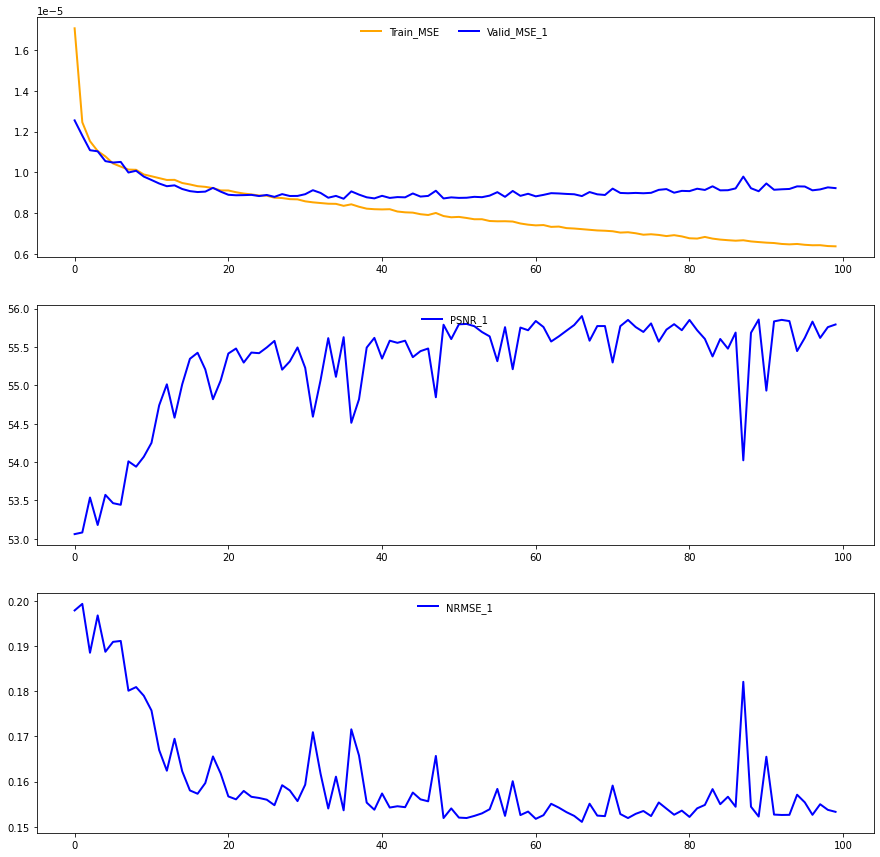

In [9]:
utils.draw_chart()

In [10]:
#experimentos results
print(utils.get_experiment_results())

{'Best_Valid': 55.90195032288531, 'Best_Epoch': 66, 'PSNR_1': 55.90195032288531, 'PSNR_2': 0, 'PSNR_3': 0, 'NRMSE_1': 0.15110112494085526, 'NRMSE_2': 0, 'NRMSE_3': 0}


In [9]:
#load best model
model.load_weights(utils.get_exp_folder_best_valid())
CONST_GAMA = 0.001

qtd_traning = valid_x_1.shape
print("Loaded",qtd_traning, "samples")

#batches
num_val_minibatches = math.floor(valid_x_1.shape[0]/mini_batch_size)

#metrics
val_mse = tf.keras.metrics.MeanSquaredError(name='val_mse')
val_custom_metrics = utils.CustomMetric()

import json
f = open('/home/arthursrr/Documentos/Audio_Inpainting/Datasets/idx_genders_val.json', "r") 
idx_gen = json.loads(f.read()) 

for k in idx_gen:
    for i in tqdm(idx_gen[k]):
        data_x = valid_x_1[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        data_y = valid_y_1[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

        data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
        data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)

        data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA

        predictions = model(data_x)
        val_mse(data_y, predictions)

        predictions = predictions.numpy()
        data_y = data_y.numpy()

        #feed the metric evaluator
        val_custom_metrics.feed(data_y, predictions)

    #get metric results
    psnr, nrmse = val_custom_metrics.result()
    val_mse_result = val_mse.result().numpy()
    val_custom_metrics.reset_states()
    val_mse.reset_states()
    
    print(k ,"\nPSNR:", psnr,"\nNRMSE:", nrmse)

# Closing file 
f.close() 

  0%|          | 0/200 [00:00<?, ?it/s]

Loaded (92800, 128, 128, 1) samples


  0%|          | 1/200 [00:00<00:22,  8.84it/s]

Electronic 
PSNR: 53.7744413368859 
NRMSE: 0.15338781996308548


  0%|          | 1/200 [00:00<00:22,  8.91it/s]

Experimental 
PSNR: 57.52426832346921 
NRMSE: 0.15632387859872648


  0%|          | 1/200 [00:00<00:21,  9.08it/s]

Rock 
PSNR: 52.677620296488826 
NRMSE: 0.16966087968808444


  0%|          | 1/200 [00:00<00:22,  8.70it/s]

Hip-Hop 
PSNR: 53.05857069333048 
NRMSE: 0.15274213280913193


  0%|          | 1/200 [00:00<00:21,  9.30it/s]

Folk 
PSNR: 58.254749108503304 
NRMSE: 0.13782233820986234


  0%|          | 1/200 [00:00<00:22,  8.83it/s]

Instrumental 
PSNR: 59.1735785654521 
NRMSE: 0.14381770471454988


  0%|          | 0/200 [00:00<?, ?it/s]

Pop 
PSNR: 54.99854292994886 
NRMSE: 0.1547407701570666


100%|██████████| 200/200 [00:22<00:00,  8.95it/s]

International 
PSNR: 57.75383132168368 
NRMSE: 0.14031347579104145


## Test

In [ ]:
#load best model
model.load_weights(utils.get_exp_folder_best_valid())

test_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_test.npy", mmap_mode='c') 
test_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test.npy", mmap_mode='c')

qtd_traning = test_x.shape
print("Loaded",qtd_traning, "samples")

# #normalization
# test_x = utils.shift_and_normalize(test_x, SHIFT_VALUE_X, SCALE_VALUE_X)
# test_y = utils.shift_and_normalize(test_y, SHIFT_VALUE_Y, SCALE_VALUE_Y) 

#batches
num_test_minibatches = math.floor(test_x.shape[0]/mini_batch_size)
# test_batches = utils.random_mini_batches(test_x, test_y, None, None, 8, seed=0)

#metrics
test_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
test_custom_metrics = utils.CustomMetric()

#test
for i in tqdm(range(num_test_minibatches)):
    data_x = test_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
    data_y = test_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

    data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
    data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)

    data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
    data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA

    predictions = model(data_x)
    test_mse(data_y, predictions)

    predictions = predictions.numpy()
    data_y = data_y.numpy()

    #feed the metric evaluator
    test_custom_metrics.feed(data_y, predictions)

    #just show the first example of each batch until 5    
#     print("Spatial domain: X - Y - PREDICT - DIFF")
#     plt.imshow(np.hstack((data_x[0,:,:,0], data_y[0,:,:,0], predictions[0,:,:,0], np.abs(predictions[0,:,:,0]-seismic_y[0,:,:,0]))) , cmap='Spectral', vmin=0, vmax=1)
#     plt.axis('off')
#     plt.pause(0.1)
    
    #ATENÇÃO!!
    
    #predictions = inv_shift_and_normalize(predictions, SHIFT_VALUE_Y, SCALE_VALUE_Y)
    #np.save(outfile_path, predictions)
    
#get metric results
psnr, nrmse = test_custom_metrics.result()
test_mse_result = test_mse.result().numpy()
test_custom_metrics.reset_states()
test_mse.reset_states()
    
print("PSNR:", psnr,"\nNRMSE", nrmse)


In [12]:
#load best model
model.load_weights(utils.get_exp_folder_best_valid())
CONST_GAMA = 0.001
test_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_test.npy", mmap_mode='c') 
test_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test.npy", mmap_mode='c')

qtd_traning = test_x.shape
print("Loaded",qtd_traning, "samples")

# #normalization
# test_x = utils.shift_and_normalize(test_x, SHIFT_VALUE_X, SCALE_VALUE_X)
# test_y = utils.shift_and_normalize(test_y, SHIFT_VALUE_Y, SCALE_VALUE_Y) 

#batches
num_test_minibatches = math.floor(test_x.shape[0]/mini_batch_size)
# test_batches = utils.random_mini_batches(test_x, test_y, None, None, 8, seed=0)

#metrics
test_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
test_custom_metrics = utils.CustomMetric()

import json
f = open ('/home/arthursrr/Documentos/Audio_Inpainting/Datasets/idx_genders_test.json', "r") 
idx_gen = json.loads(f.read()) 

for k in idx_gen:
    for i in tqdm(idx_gen[k]):
        data_x = test_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        data_y = test_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

        data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
        data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)

        data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA

        predictions = model(data_x)
        test_mse(data_y, predictions)

        predictions = predictions.numpy()
        data_y = data_y.numpy()

        #feed the metric evaluator
        test_custom_metrics.feed(data_y, predictions)

    #get metric results
    psnr, nrmse = test_custom_metrics.result()
    test_mse_result = test_mse.result().numpy()
    test_custom_metrics.reset_states()
    test_mse.reset_states()
    
    print(k ,"\nPSNR:", psnr,"\nNRMSE:", nrmse)

# Closing file 
f.close() 

  0%|          | 0/638 [00:00<?, ?it/s]

Loaded (323988, 128, 128, 1) samples


  0%|          | 1/625 [00:00<01:07,  9.31it/s]

Electronic 
PSNR: 53.9042016156341 
NRMSE: 0.15560563456302054


  0%|          | 1/619 [00:00<01:07,  9.12it/s]

Experimental 
PSNR: 58.01833947353213 
NRMSE: 0.15614642382291358


  0%|          | 1/609 [00:00<01:08,  8.93it/s]

Classical 
PSNR: 68.07529501741071 
NRMSE: 0.11689648077003097


  0%|          | 1/585 [00:00<01:04,  9.07it/s]

Rock 
PSNR: 53.14390140805312 
NRMSE: 0.17038005691994831


  0%|          | 1/518 [00:00<00:55,  9.35it/s]

Hip-Hop 
PSNR: 53.38352347662636 
NRMSE: 0.15292128016743797


  0%|          | 1/510 [00:00<00:56,  9.07it/s]

Folk 
PSNR: 58.84453121721164 
NRMSE: 0.13707295707040745


  0%|          | 1/384 [00:00<00:42,  9.01it/s]

Old-Time / Historic 
PSNR: 63.734943372691575 
NRMSE: 0.11903988271041756


  0%|          | 1/349 [00:00<00:38,  8.94it/s]

Jazz 
PSNR: 59.85550775809217 
NRMSE: 0.1381201888947449


  1%|          | 1/186 [00:00<00:20,  9.09it/s]

Instrumental 
PSNR: 58.12734402463414 
NRMSE: 0.148924838504934


  1%|          | 1/178 [00:00<00:18,  9.66it/s]

Pop 
PSNR: 55.469526900863265 
NRMSE: 0.1565684323594401


  1%|          | 1/154 [00:00<00:16,  9.10it/s]

Country 
PSNR: 55.07853716133873 
NRMSE: 0.1550063919381874


  1%|          | 1/118 [00:00<00:12,  9.08it/s]

Soul-RnB 
PSNR: 52.99961686041765 
NRMSE: 0.15982011731037


  1%|▏         | 1/74 [00:00<00:08,  9.01it/s]

Spoken 
PSNR: 64.7603995184228 
NRMSE: 0.1262511434565018


  5%|▍         | 1/21 [00:00<00:02,  9.04it/s]

Blues 
PSNR: 57.7827974751198 
NRMSE: 0.14517958242313544


  6%|▌         | 1/18 [00:00<00:01,  8.95it/s]

Easy Listening 
PSNR: 56.932485147679216 
NRMSE: 0.14505874917373401


100%|██████████| 18/18 [00:01<00:00,  9.55it/s]

International 
PSNR: 61.47011739435076 
NRMSE: 0.12921746695651842


In [9]:
def griffin_lim(S, frame_length=256, fft_length=255, stride=64):
    '''
    TensorFlow implementation of Griffin-Lim
    Based on https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb
    '''
    S = tf.expand_dims(S, 0)
    S_complex = tf.identity(tf.cast(S, dtype=tf.complex64))
    y = tf.signal.inverse_stft(S_complex, frame_length, stride, fft_length=fft_length)
    for i in range(1000):
        est = tf.signal.stft(y, frame_length, stride, fft_length=fft_length)
        angles = est / tf.cast(tf.maximum(1e-16, tf.abs(est)), tf.complex64)
        y = tf.signal.inverse_stft(S_complex * angles, frame_length, stride, fft_length=fft_length)
    return tf.squeeze(y, 0)

In [27]:
model.load_weights(utils.get_exp_folder_best_valid())

test_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_test.npy", mmap_mode='c') 
test_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test.npy", mmap_mode='c')

qtd_traning = test_x.shape
print("Loaded",qtd_traning, "samples")

#batches
num_test_minibatches = math.floor(test_x.shape[0]/mini_batch_size)

#metrics
test_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
test_custom_metrics = utils.CustomMetric()

i=462
CONST_GAMA = 0.001

data_x = test_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
data_y = test_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)

data_norm = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA

predictions = model(data_norm)

predictions = utils.inv_shift_and_normalize(predictions, SHIFT_VALUE_Y, SCALE_VALUE_Y)


Loaded (323988, 128, 128, 1) samples


In [28]:
audio_pred = None
for i in range(0, 58):
    if i==0:
        audio_pred = predictions[i,:,:,0]
    else:
        audio_pred = np.concatenate((audio_pred, predictions[i,:,:,0]), axis=0)
audio_pred.shape

(7424, 128)

In [29]:
audio_corte = None
for i in range(0, 58):
    if i==0:
        audio_corte = data_x[i,:,:,0]
    else:
        audio_corte = np.concatenate((audio_corte, data_x[i,:,:,0]), axis=0)
audio_corte.shape

(7424, 128)

In [30]:
audio_original = None
for i in range(0, 58):
    if i==0:
        audio_original = data_y[i,:,:,0]
    else:
        audio_original = np.concatenate((audio_original, data_y[i,:,:,0]), axis=0)
audio_original.shape

(7424, 128)

In [31]:
import IPython.display as ipd
wave_original = griffin_lim(audio_original, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_original, rate=16000)

In [32]:
wave_corte = griffin_lim(audio_corte, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_corte, rate=16000)

In [23]:
wave_pred = griffin_lim(audio_pred, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_pred, rate=16000)

In [ ]:
import soundfile as sf
sf.write('original.wav', wave_original, 16000, subtype='PCM_16')
sf.write('corte.wav', wave_corte, 16000, subtype='PCM_16')
sf.write('pred.wav', wave_pred, 16000, subtype='PCM_16')